(confidence-interval-notebook)=
# Intervallo di confidenza

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import arviz as az
import pymc as pm
import pymc.sampling_jax
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## La variabilità campionaria

Quando si estrae un campione casuale da una popolazione, la statistica calcolata su quel campione sarà diversa dal parametro della popolazione a causa della variabilità campionaria. Per valutare l'errore che si commette nella stima del parametro, l'approccio frequentista descrive la variazione della stima attorno al parametro della popolazione, ovvero la dispersione della *distribuzione campionaria* dello stimatore. 

Come abbiamo visto in precedenza, possiamo usare la deviazione standard di una variabile casuale per misurare la dispersione della sua distribuzione. Purtroppo, nella maggior parte dei casi non possiamo calcolare direttamente la deviazione standard della distribuzione campionaria di uno stimatore. Ciò richiederebbe di estrarre molteplici campioni dalla popolazione di interesse, ma raramente abbiamo accesso a più di un campione. Invece, dobbiamo *stimare* la deviazione standard della distribuzione campionaria basandoci sul singolo campione che abbiamo estratto. La stima della deviazione standard della distribuzione campionaria di uno stimatore viene chiamata *errore standard* dello stimatore.
 
L'errore standard è la deviazione standard della distribuzione della stima del parametro nell'universo dei campioni e quantifica l'incertezza relativa alla stima del parametro. Mediante l'errore standard, l'approccio frequentista costruisce l'intervallo fiduciale, che fornisce una stima dell'intervallo di valori in cui ci si aspetta che, *a lungo termine*, il parametro cada con una certa probabilità.

## L'intervallo fiduciale

Gli statistici frequentisti utilizzano l'errore standard per quantificare l'incertezza associata alle stime campionarie e costruire un intervallo di valori noto come "intervallo di fiducia". I limiti dell'intervallo di fiducia, chiamati "limiti fiduciari", possono variare da campione a campione, ma si prevede che contengano il vero valore del parametro con una probabilità $\gamma$ a lungo termine. In pratica, se il livello di fiducia è del 95%, ci si aspetta che il vero valore del parametro si trovi nel 95% degli intervalli di fiducia costruiti. L'intervallo di fiducia può essere calcolato per vari parametri, come la media, la varianza o la proporzione di una popolazione.

## Calcolo dell'intervallo fiduciale

In alcune situazioni, la distribuzione delle statistiche ottenute dai campioni si approssima alla distribuzione Normale e, in questi casi, l'intervallo fiduciale al 95% è dato da:

$$
\hat{\theta} \pm 1.96 \cdot \text{SE},
$$

ovvero, è uguale alla stima del parametro più o meno 1.96 volte l'errore standard.

### Derivazione

Possiamo ottenere la formula precedente nel seguente modo. Supponiamo di avere una popolazione normale con media $\mu$ e varianza $\sigma^2$ e di estrarre un campione casuale $X_1, X_2, \dots, X_n$ da essa. Per le proprietà della distribuzione normale, anche la media campionaria seguirà una distribuzione normale: $\bar{X} \sim \mathcal{N}(\mu, \sigma/n)$. Di conseguenza, la media campionaria standardizzata seguirà una distribuzione normale standard:

$$
\frac{\bar{X} - \mu}{\sigma/\sqrt{n}} \sim \mathcal{N}(0, 1).
$$

Fissato un livello di confidenza $\gamma = 1 - \alpha$ (tipicamente $\gamma = 0.95$, corrispondente a $\alpha = 0.05$), possiamo trovare il valore di $z$ corrispondente al quantile di ordine $1 - \alpha/2$ della distribuzione normale standard (chiamato "coefficiente fiduciario"). In altre parole, $z$ rappresenta il valore tale che la probabilità che una variabile casuale normale standardizzata assuma un valore compreso tra $-z$ e $z$ sia pari a $1 - \alpha$: $P(-z \leq Z \leq z) = 1 - \alpha$.

Utilizzando questa informazione, possiamo scrivere l'intervallo di confidenza per la media popolazionale come:

$$
\begin{equation}
P\Bigg(-z \leq \frac{\bar{X} - \mu}{\sigma/\sqrt{n}} \leq z\Bigg) = 1 - \alpha.
\end{equation}
$$

Questo intervallo di confidenza rappresenta l'intervallo in cui ci aspettiamo che la media popolazionale cada con una certa probabilità, basata sul campione casuale estratto. L'intervallo di confidenza per la media popolazionale può essere quindi utilizzato per inferire informazioni sulla popolazione sulla base delle proprietà del campione estratto.

Applicando qualche manipolazione algebrica, la diseguaglianza precedente si può scrivere
nel modo seguente:

$$
\begin{align}
P\bigg(-z \leq &\frac{ \bar{X} - \mu } {\sigma} \sqrt{n} \leq z\bigg) = 1 − \alpha\notag\\
P\bigg(-z {\frac{\sigma}{\sqrt{n}}} \leq  &\bar{X} - \mu \leq z \frac{\sigma}{\sqrt{n}}\bigg) = 1 − \alpha\notag\\
P\bigg(-\bar{X}-z {\frac{\sigma}{\sqrt{n}}} \leq &-\mu \leq -\bar{X} + z \frac{\sigma}{\sqrt{n}}\bigg) = 1 − \alpha\notag\\
P\bigg(\bar{X}+z \frac{\sigma}{\sqrt{n}} \geq &\mu \geq  \bar{X} -z \frac{\sigma}{\sqrt{n}}\bigg) = 1 − \alpha.\notag
\end{align}
$$

Possiamo definire l'intervallo di confidenza per una stima della media al livello fiduciario $\gamma = 1 − \alpha$ come l'intervallo $(\hat{a}, \hat{b})$ dove:

$$
\begin{equation}
\hat{a} \triangleq \bar{X} -z \frac{\sigma}{\sqrt{n}}, 
\quad \hat{b} \triangleq \bar{X} +z \frac{\sigma}{\sqrt{n}},
\end{equation}
$$

e tale che $P(\hat{a} \leq \mu \leq \hat{b}) = 1 − \alpha$. In altre parole, l'intervallo di confidenza contiene il vero valore del parametro della media $\mu$ con probabilità $\gamma$. Questo tipo di intervallo è comunemente utilizzato nelle applicazioni pratiche dell'inferenza frequentista.

### Popolazione con varianza incognita

In ogni applicazione concreta, lo sperimentatore estrae un solo campione $x_1, \dots, x_n$ dalla popolazione e la varianza $\sigma^2$, in aggiunta alla media $\mu$ da determinare,  è sconosciuta. In tal caso, per effettuare una stima intervallare di $\mu$ ci si basa sulla densità $t$-Student.

L'inferenza frequentista per il caso di $\sigma^2$ ignoto si basa sul Teorema per cui 

$$
\begin{equation}
P\bigg(−t^{\ast} \leq \frac{\bar{X} - \mu}{s} \sqrt{n} \leq t^{\ast}\bigg) = 1 − \alpha,
\end{equation}
$$

dove $s$ è lo stimatore di $\sigma$ e $t^{\ast} \triangleq t_{n−1,1−\alpha/2}$ è il quantile di ordine $1 − \alpha/2$ della distribuzione $t_{n−1}$. Pertanto, il limite inferiore $\hat{a}$ e il limite superiore $\hat{b}$ dell'intervallo di confidenza diventano, rispettivamente, uguali a:

$$
\begin{equation}
\hat{a} \triangleq \bar{X} -t^{\ast} \frac{s}{\sqrt{n}}, 
\quad \hat{b} \triangleq \bar{X} + t^{\ast} \frac{s}{\sqrt{n}}.
\end{equation}
$$

Si noti che, nel caso di una popolazione con varianza sconosciuta, i limiti fiduciari si ottengono come nel caso precedente ($\sigma^2$ nota) sostituendo $\sigma$, ora incognito, con $s$ (per una ampiezza campionaria $n$ qualsiasi), e il coefficiente $z$ con $t_{n−1,1−\alpha/2}$.

La presente derivazione è stata ricavata nella ipotesi che la popolazione sia normalmente distribuita e vale anche per *piccoli campioni* ($n < 30$) estratti casualmente da questa. Se invece, nel caso di piccoli campioni, la popolazione non è normalmente distribuita, non sono soddisfatte le ipotesi che sono state qui presentate e l'intervallo di fiducia non può essere calcolato con la procedura presente. 

Per una popolazione con distribuzione diversa da quella normale, le stime intervallari per la media della popolazione si possono ancora ottenere se la numerosità del campione è sufficientemente elevata ($n \geq 30$), come conseguenza del teorema del limite centrale.

## Il livello di copertura

Sebbene calcolare l'intervallo di fiducia per la media della popolazione sia relativamente semplice, la sua interpretazione può risultare meno intuitiva. Per comprendere correttamente l'intervallo di fiducia, è necessario considerare il concetto di *livello di copertura*. In pratica, il livello di copertura rappresenta la probabilità che l'intervallo di fiducia contenga il valore del parametro sconosciuto *a lungo termine*. Ad esempio, se il livello di copertura è del 95%, ci aspettiamo che l'intervallo di fiducia contenga il valore del parametro con una probabilità del 95%. Tuttavia, non dobbiamo confondere il livello di copertura con la probabilità che il valore del parametro cada all'interno dell'intervallo di fiducia, poiché il parametro è un valore fisso e non ha una distribuzione di probabilità. Invece, l'intervallo di fiducia è una stima intervallare che può contenere o meno il valore del parametro.

Il livello di copertura di un intervallo di confidenza rappresenta la probabilità a lungo termine che la procedura di costruzione di tale intervallo produca un intervallo che contenga il vero valore del parametro di interesse. Questo concetto è fondamentale nella statistica frequentista, dove la probabilità viene definita come la proporzione di volte in cui un evento si verifica nel caso di molteplici ripetizioni dell'esperimento casuale sotto le medesime condizioni. Nel contesto della costruzione dell'intervallo di confidenza, l'esperimento casuale è l'estrazione di un campione casuale dalla popolazione e il risultato dell'esperimento casuale è l'intervallo di fiducia (che può essere diverso in ciascun campione). Il livello di copertura, solitamente indicato con $1-\alpha$, rappresenta la probabilità a lungo termine che l'intervallo di fiducia contenga il vero valore del parametro, dove $\alpha$ rappresenta il livello di significatività scelto per l'intervallo di confidenza.

Per aiutare a comprendere meglio questo concetto, possiamo eseguire una simulazione. Consideriamo la popolazione dell'altezza degli adulti maschi italiani, supponendo che essa segua una distribuzione normale con media di $175$ cm e varianza di $49$ cm$^2$. Successivamente, effettuiamo una simulazione nella quale consideriamo 1000 ripetizioni dell'esperimento casuale, che consiste nell'estrazione di un campione casuale di dimensione $n=20$ dalla popolazione descritta sopra. Per ogni campione, calcoliamo l'intervallo di confidenza al 95% come segue:

$$
\bar{X} \pm t \frac{s}{\sqrt{n}},
$$

dove $\bar{X}$ è la media campionaria, $s$ è la deviazione standard campionaria e $t$ è il valore critico della distribuzione t di Student con $n-1$ gradi di libertà e livello di significatività $\alpha/2=0.025$.

Successivamente, salviamo i limiti inferiori e superiori di ogni intervallo di confidenza così calcolato. Infine, verifichiamo quanti di questi intervalli contengono effettivamente il valore reale del parametro della popolazione.

Partiamo generando 1000 campioni casuali di dimensione $n=30$ da una distribuzione normale con media $175$ e deviazione standard $7$.

In [3]:
mu = 175
sigma = 7
n = 30
n_samples = 1000

samples = np.stack([np.random.normal(loc=mu, scale=sigma, size=n) for i in range(n_samples)])
samples.shape

(1000, 30)

Il primo campione di ampiezza $n$ = 30 che abbiamo ottenuto è il seguente.

In [4]:
print(*samples[1, :])

189.4344460959392 182.5960362396509 170.85583851721017 181.1225970463226 164.95373060144215 151.43629858806955 169.973603783907 171.6661606133333 165.1180188191428 176.92318035596207 184.33592411304986 183.39853774309583 169.2271993198021 163.6238459467759 176.44603118569358 161.91220215706028 178.43295591510227 169.37250332669524 165.9682950732885 178.7252529801918 173.5598748495419 169.53372589890378 180.0406098032309 171.76505795522874 178.70829646682927 174.76800091167362 171.25895215942023 171.17552244195107 175.36031193619175 180.0109009885003


Stampiamo qui di seguito le medie dei primi dieci campioni.

In [5]:
xbar = samples.mean(axis=1)
print(*xbar[0:10])

174.12261638120648 173.3901303944402 174.59951158991697 176.460621156997 175.25042214148505 175.852114296647 174.82360380035328 177.157345196308 177.6662610801808 174.23680475910064


Troviamo ora il valore critico della distribuzione $t$ di Student con (30-1) gradi di libertà.

In [6]:
alpha = 0.05
t = st.t.ppf(1 - alpha/2, n-1)
t

2.045229642132703

Utilizzando le informazioni precedenti, possiamo calcolare 1000 intervalli di confidenza per la media della popolazione.

In [7]:
interval_width = t * samples.std(axis=1, ddof=1) / np.sqrt(n)
CI_low = samples.mean(axis=1) - interval_width
CI_high = samples.mean(axis=1) + interval_width

Calcoliamo ora il livello di copertura, ovvero il numero di volte in cui l'intervallo di confidenza calcolato contiene il vero valore del parametro.

In [8]:
coverage_p = np.sum(np.logical_and(CI_low < mu, mu < CI_high)) / samples.shape[0]
coverage_p

0.949

In conclusione, ripetendo la simulazione per 1000 volte, abbiamo ottenuto una proporzione di intervalli di confidenza del 95% che contengono il parametro (ovvero il livello di copertura) molto vicino al valore nominale di $1 - \alpha = 0.95$.

## Interpretazione

Gli intervalli di confidenza rappresentano un intervallo di valori che, con un determinato livello di confidenza, contiene il parametro di interesse. Tuttavia, è importante fare una distinzione tra il livello di confidenza e la probabilità che il parametro sia contenuto all'interno dell'intervallo. Il livello di confidenza si riferisce alla proporzione di volte in cui l'intervallo di confidenza copre il vero valore del parametro, e non alla probabilità che il parametro cada all'interno dell'intervallo. In altre parole, se l'esperimento venisse ripetuto molte volte, l'intervallo di confidenza conterrà il parametro di interesse nel 95% dei casi, se il livello di confidenza è del 95%.

```{admonition} Definizione
In termini frequentisti, l'intervallo di confidenza va interpretato come la procedura di calcolo che, se ripetuta molte volte, producirà un intervallo che coprirà il valore reale del parametro con una certa probabilità, data dal livello di confidenza scelto. Tuttavia, non possiamo affermare con certezza che un particolare intervallo di confidenza contenga il vero valore del parametro. L'importante distinzione da fare è che il livello di confidenza non è la probabilità che il parametro si trovi nell'intervallo, ma la probabilità che l'intervallo contenga il parametro se l'esperimento viene ripetuto molte volte.
```

L'interpretazione corretta dell'intervallo di confidenza al livello $100 (1-\alpha)$% è quella secondo cui, se ripetessimo l'esperimento di estrazione di un campione casuale e il calcolo dell'intervallo di confidenza molte volte, allora in circa $100 (1-\alpha)$% dei casi gli intervalli così calcolati conterranno il vero valore del parametro. Tuttavia, è noto che spesso i ricercatori (e non solo gli studenti) commettono l'errore di attribuire agli intervalli di confidenza un'interpretazione errata, come ad esempio: "la probabilità che la media della popolazione $\mu$ sia contenuta nell'intervallo $[\hat{a}, \hat{b}]$ è del 95%". La formulazione corretta sarebbe invece: "la procedura utilizzata per calcolare l'intervallo $[\hat{a}, \hat{b}]$ ha una probabilità del 95% di produrre un intervallo che copre il valore reale del parametro". In sintesi, l'intervallo di confidenza non fornisce una probabilità sulla posizione del parametro, ma piuttosto una probabilità sulla capacità della procedura utilizzata per calcolare l'intervallo di produrre un intervallo che copre il valore reale del parametro.

### Fraintendimenti

Nel lavoro di {cite}`hoekstra2014robust` si evidenzia come, dato che i limiti del test di ipotesi nulle sono ampiamente riconosciuti, spesso per l'inferenza statistica venga consigliato l'utilizzo degli intervalli di confidenza. In particolare, il Manuale di Pubblicazione dell'American Psychological Association suggerisce che gli intervalli di confidenza siano "in generale, la migliore strategia di reportistica" (APA, 2001, p. 22; APA, 2009, p. 34). Tuttavia, {cite}`hoekstra2014robust` mettono in evidenza che tali raccomandazioni presentano dei limiti, in quanto non tengono conto della difficoltà dei ricercatori nel fornire una corretta interpretazione degli intervalli di confidenza. A supporto di questo punto di vista, {cite}`hoekstra2014robust` hanno condotto uno studio in cui si pongono due domande:

- In che misura gli intervalli di confidenza sono interpretati in modo errato da studenti e ricercatori?
- Le interpretazioni errate degli intervalli di confidenza diminuiscono con l'esperienza nella ricerca?

Prima di presentare lo studio, {cite}`hoekstra2014robust` ricordano qual è l'interpretazione corretta degli intervalli di confidenza. 

> A CI is a numerical interval constructed around the estimate of a parameter. Such an interval does not, however, directly indicate a property of the parameter; instead, it indicates a property of the procedure, as is typical for a frequentist technique. Specifically, we may find that a particular procedure, when used repeatedly across a series of hypothetical data sets (i.e., the sample space), yields intervals that contain the true parameter value in 95% of the cases. When such a procedure is applied to a particular data set, the resulting interval is said to be a 95% CI. The key point is that the CIs do not provide for a statement about the parameter as it relates to the particular sample at hand; instead, they provide for a statement about the performance of the procedure of drawing such intervals in repeated use. Hence, it is incorrect to interpret a CI as the probability that the true value is within the interval (e.g., Berger & Wolpert, 1988). As is the case with $p$-values, CIs do not allow one to make probability statements about parameters or hypotheses.

Nel loro studio, {cite:t}`hoekstra2014robust` hanno sottoposto il questionario riportato di seguito ad un campione di 596 partecipanti. Il campione includeva 442 studenti di psicologia del primo anno che seguivano un corso introduttivo di statistica presso l'università di Amsterdam, 34 studenti di master e 120 ricercatori (cioè dottorandi e docenti universitari).

> Professor Bumbledorf conducts an experiment, analyzes the data, and reports: "The 95% confidence interval for the mean ranges from 0.1 to 0.4." Please mark each of the statements below as 'true' or 'false'.

> 1.  The probability that the true mean is greater than 0 is at least 95%.
> 2.  The probability that the true mean equals 0 is smaller than 5%.
> 3.  The "null hypothesis" that the true mean equals 0 is likely to be incorrect.
> 4.  There is a 95% probability that the true mean lies between 0.1 and 0.4.
> 5.  We can be 95% confident that the true mean lies between 0.1 and 0.4.
> 6.  If we were to repeat the experiment over and over, then 95% of the time the true mean falls between 0.1 and 0.4.

Le sei affermazioni precedenti sono tutte errate. I risultati dello studio di {cite:t}`hoekstra2014robust` mostrano però che i partecipanti si sono dichiarati d'accordo con il seguente numero medio di item (su 6): 3.51 (99% CI = \[3.35, 3.68\]) per gli studenti del primo anno, 3.24 (99% CI = \[2.40, 4.07\]) per gli studenti di master e 3.45 (99% CI = \[3.08, 3.82\]) per i ricercatori. Gli intervalli di fiducia al 95% si sovrappongono per le tre categorie di rispondenti il che significa che, a tale livello di fiducia, non c'è ragione di ritenere che vi siano delle differenze tra i tre gruppi di rispondenti. In altre parole, questi dati suggeriscono che i ricercatori tendono a condividere con gli studenti di psicologia del primo anno le stesse opinioni (errate!) relativamente agli intervallo fiduciali.

Le interpretazioni errate degli intervalli di fiducia sono dunque molto diffuse e l'esperienza pratica nel mondo della ricerca non contribuisce ad una comprensione migliore di tale concetto. In generale, i risultati della ricerca di {cite:t}`hoekstra2014robust`, e di altre che hanno prodotto risultati simili, mettono in discussione l'utilità degli intervalli fiduciali frequentisti (dato che poche persone hanno una comprensione adeguata di tale concetto), favorendo invece l'uso degli "intervallo di credibilità" Bayesiani ai quali è più facile fornire un'interpretazione corretta, perché tale interpretazione coincide con le nostre intuizioni.

## Confronto tra intervalli frequentisti e bayesiani

Concludiamo la discussione di questo capitolo presentando un confronto tra l'intervallo di confidenza frequentista e l'intervallo di credibilità bayesiano calcolati a partire dagli stessi dati. 

### Intervallo di confidenza

Supponiamo di disporre di un insieme di $n$ = 20 osservazioni che riguardano la prestazione in un compito cognitivo e di volere stimare la media della popolazione da cui quelle osservazioni sono state estratte.  Simuliamo 20 valori a caso dalla popolazione $\mathcal{N}(50, 10)$.

In [9]:
sample_size = 20
mu = 50
sigma = 10
sample_data = np.random.normal(loc=mu, scale=sigma, size=n)
print(sample_data)

[43.33939073 41.47509852 45.85082387 58.26839702 43.94684396 57.22797263
 52.28179389 42.12740231 70.57492424 45.79404101 57.91439542 46.65270764
 47.34329888 50.2913576  33.90041467 57.01128281 43.0105157  72.79372673
 59.07759708 55.97692286 57.97111907 45.45985409 48.58535885 51.0018009
 38.97303418 61.75050194 66.10509122 49.25792799 27.11641074 49.28075804]


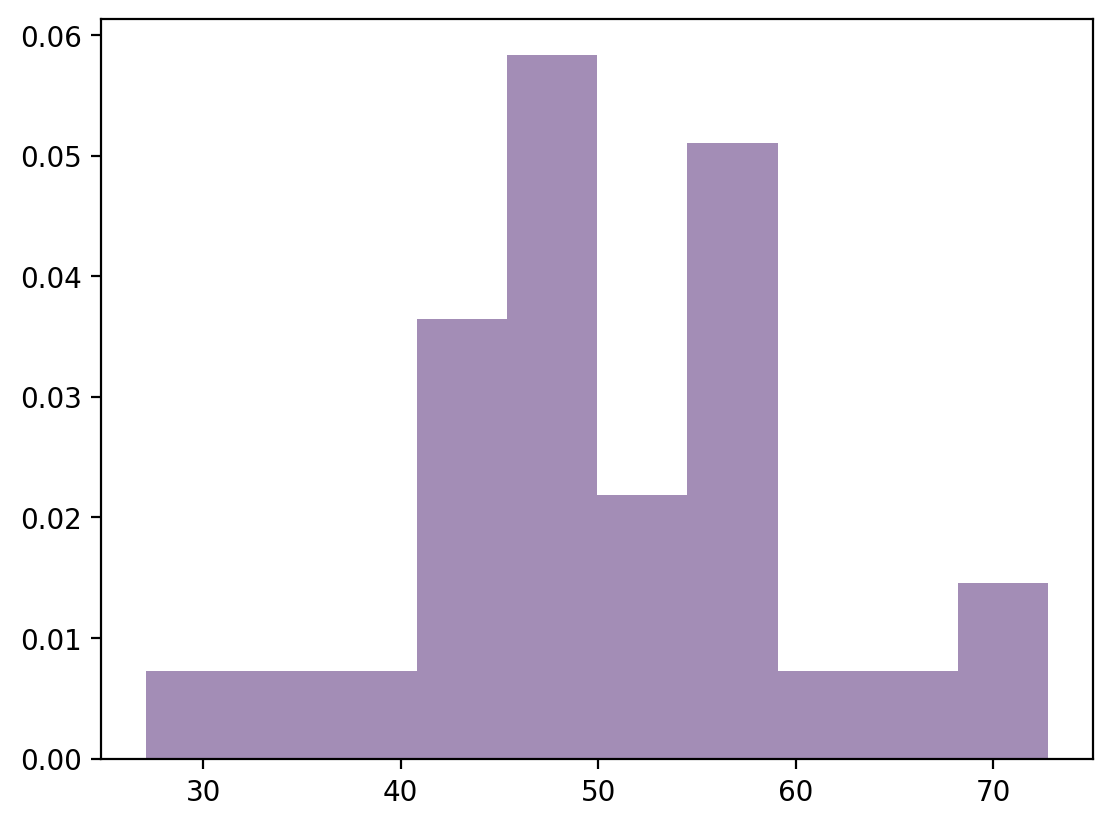

In [10]:
plt.hist(sample_data, density=True, alpha=0.5)
plt.show()

Un modo per affrontare il problema della stima di $\mu$ utilizzando un approccio frequentista è attraverso la stima puntuale. La stima puntuale prevede l'utilizzo di un singolo valore, come ad esempio la media campionaria, per rappresentare il parametro della popolazione sconosciuto. 

La media campionaria, $\hat{\mu}$, è una stima puntuale comunemente usata per la media della popolazione, $\mu$. Viene calcolata come la somma dei valori campionari, $x_1, x_2, ..., x_n$, divisa per la dimensione del campione, $n$:

$$\hat{\mu} = \frac{1}{n} \sum_{i=1}^n x_i.$$

Per i dati dell'esempio, abbiamo

In [11]:
sample_mean = np.mean(sample_data)
sample_mean

50.67869215351195

Tuttavia, le stime puntuali da sole non forniscono una caratterizzazione completa dell'incertezza relativa alla stima. Per quantificare questa incertezza, l'approccio frequentista utilizza  l'intervallo di confidenza. Un intervallo di confidenza è una stima dell'intervallo probabile del vero parametro della popolazione basata sui dati osservati, e viene costruito aggiungendo e sottraendo un margine di errore dalla stima puntuale: 

$$\hat{\mu} \pm m = [\hat{\mu} - m, \hat{\mu} + m].$$

Il margine di errore è determinato dal livello di confidenza desiderato e dalla dimensione del campione, e riflette la variabilità nei dati del campione. Ad esempio, un intervallo di confidenza del 95% indica che la procedura che abbiamo usato produce un risultato corretto (ovvero il fatto che il vero parametro della popolazione si trovi all'interno dell'intervallo) nel 95% dei casi.

Il margine di errore è determinato dal livello di confidenza desiderato, $1-\alpha$, e dalla dimensione del campione, $n$. Riflette la variabilità nei dati del campione ed è calcolato tipicamente utilizzando l'errore standard, $SE$, della stima puntuale:

$$m = t_{1-\frac{\alpha}{2}, n-1} \times SE,$$

dove $t_{1-\frac{\alpha}{2}, n-1}$ è il valore critico della distribuzione $t$ con $n-1$ gradi di libertà per il livello di confidenza desiderato.

L'errore standard della media del campione è calcolato come la deviazione standard del campione, $\sigma$, divisa per la radice quadrata della dimensione del campione:

$$SE = \frac{\sigma}{\sqrt{n}}.$$

Per i dati dell'esempio, la deviazione standard del campione è

In [12]:
sample_stddev = np.std(sample_data, ddof=1)
sample_stddev

10.158545893150565

L'errore standard della media è

In [13]:
standard_error = sample_stddev / np.sqrt(sample_size)
print(standard_error)

2.271519916963598


L'errore standard della media rappresenta una stima della deviazione standard della distribuzione delle medie campionarie per campioni di dimensione $n$ (in questo caso, $n$ = 20).

Supponiamo di voler avere un livello di confidenza del 95%. Per trovare il valore critico della distribuzione $t$ di Student, dobbiamo trovare il valore della statistica $T$ che lascia il 2.5% dell'area sotto la coda a sinistra e il 2.5% dell'area sotto la coda a destra della distribuzione $t$ di Student con 19 gradi di libertà.

In [14]:
degrees_of_freedom = sample_size - 1
t_val = st.t.ppf(0.975, degrees_of_freedom)
print(t_val)

2.093024054408263


Il margine d'errore è uguale a 

$$t \cdot SE$$

ovvero

In [15]:
margin_of_error = t_val * standard_error
print(margin_of_error)

4.754345826272271


L'intervallo di confidenza frequentista è uguale a 

$$\text{stima del parametro} \pm \text{margine d'errore}$$

ovvero

$$\bar{x} \pm t_{\text{critico}} \frac{s}{\sqrt{n}}.$$

Per i dati dell'esempio otteniamo

In [16]:
confidence_interval_lower = sample_mean - margin_of_error
confidence_interval_upper = sample_mean + margin_of_error
confidence_interval = [confidence_interval_lower, confidence_interval_upper]
print(confidence_interval)

[45.92434632723968, 55.433037979784224]


Interpretiamo questo risultato dicendo che la procedura utilizzata per calcolare l'intervallo $[42.99, 53.23]$ include $\mu$ nel 95% dei casi.

La figura successiva mostra la distribuzione dei dati, la stima di $\mu$ (ovvero, la media del campione) e l'intervalli di confidenza al 95%.

In [17]:
def visualize_output(sample_data, sample_mean, interval, type_interval):
    plt.hist(sample_data, density=True, alpha=0.5)
    plt.axvline(x=sample_mean, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(x=interval[0], color='g', linewidth=2)
    plt.axvline(x=interval[1], color='g', linewidth=2)
    plt.legend(['Sample Mean', f'{type_interval} interval'])

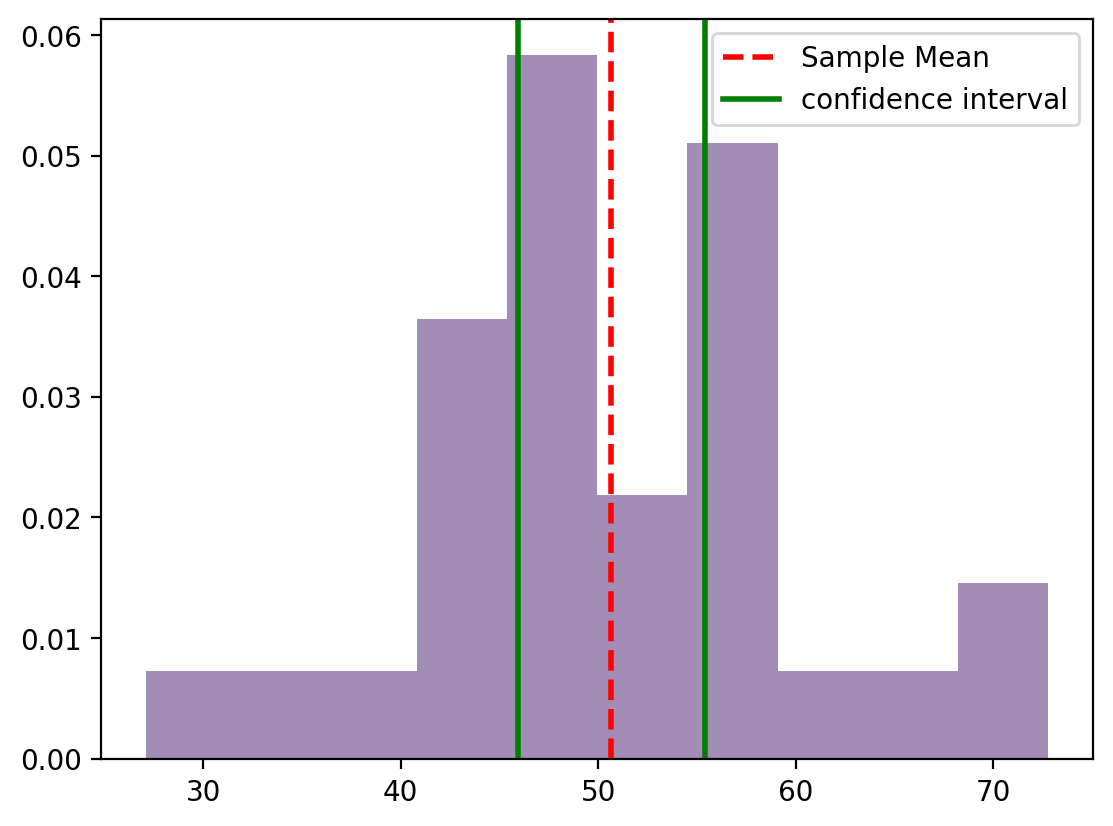

In [18]:
visualize_output(sample_data, sample_mean, confidence_interval, 'confidence')


### Intervallo di credibilità

In [19]:
model = pm.Model()

with model:
    mu = pm.Normal("mu", mu=sample_mean, sigma=20)
    sigma = pm.HalfNormal("sigma", 20)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=sample_data)

In [20]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
I0000 00:00:1698381979.975644       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
Compilation time = 0:00:22.266527
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 851.03it/s]
Sampling time = 0:00:02.830243
Transforming variables...
Transformation time = 0:00:00.102770


In [21]:
az.summary(idata, hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,50.77,1.95,47.02,54.68,0.04,0.03,2450.08,2044.99,1.0
sigma,10.54,1.43,7.98,13.38,0.03,0.02,2443.10,2397.87,1.0


Si noti che, per i dati considerati e per come il modello bayesiano è stato specificato, l'intervallo di credibilità è molto simile all'intervallo di confidenza frequentista. Tuttavia, l'interpretazione è molto più semplice: con un grado di fiducia soggettivo del 95%, possiamo affermare che la media della popolazione è contenuta nell'intervallo trovato.

## Commenti e considerazioni finali

Secondo quanto riportato da {cite:t}`hoekstra2014robust`, gli intervalli di fiducia sono frequentemente fraintesi. Il concetto di un "livello di confidenza del 95%" si riferisce alla probabilità a lungo termine che il 95% degli intervalli di fiducia calcolati conterrà il vero valore del parametro sconosciuto. Tuttavia, riguardo a un singolo intervallo di fiducia, non è possibile affermare con certezza se esso includa o escluda il parametro in questione. In altre parole, per uno specifico intervallo di fiducia, il ricercatore non può determinare se il parametro sconosciuto è effettivamente contenuto in esso.

Inoltre, è errato presupporre una relazione tra la varianza e la media di un campione per concludere che un intervallo di fiducia più stretto sia necessariamente più preciso. Nel quadro teorico frequentista, la nozione di "precisione" è collegata unicamente al livello di copertura a lungo termine garantito dal metodo utilizzato per generare gli intervalli di fiducia, e non ha pertinenza rispetto al singolo intervallo di fiducia osservato. Di conseguenza, un intervallo di fiducia che appare molto stretto potrebbe essere, in realtà, molto distante dal vero valore del parametro sconosciuto.

## Watermark

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Fri Oct 27 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

matplotlib: 3.8.0
pandas    : 2.1.1
arviz     : 0.16.1
numpy     : 1.25.2
pymc      : 5.9.1
scipy     : 1.11.3

Watermark: 2.4.3

